# Gearbox

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
s1, s2, s3, s4 = ?

while(t < T):

    v = update_v

    if gear == 1 and v >= s1 {
        gear = 0, nxt = 2, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif w < 0 and gear == 0 {
        gear = nxt;
    }

    w = w - 0.1;
```

Velocity evolves according to:
$$ \frac{d \textit{v}}{dt} = \begin{cases} v \cdot \alpha(i, v) + \textit{gauss}(5., 1.) & \text{if gear==i} \\
                                        -0.0005 v^2 + \textit{gauss}(0., 0.5) & \text{if gear==0}  \end{cases} $$

where $\alpha(i,v) = \frac{1}{1 + \frac{(v-p_i)^2}{25}}$ and $p_i = (5, 15, 25, 40, 60)$.

### Original Model

In [4]:
# Cerchiamo un'approssimazione ragionevole per alpha

#import matplotlib.pyplot as plt
#
#lb = [0, 10, 20, 30, 50]
#ub = [10, 20, 30, 50, 100]
#p = [5,15, 25, 40, 60]
#
#for i in range(5):
#    v = np.linspace(lb[i], ub[i], 100)
#    y = [1/(1+(vi - p[i])**2/25) for vi in v]
#    
#    print('Average alpha {}: '.format(i+1), np.mean(y))

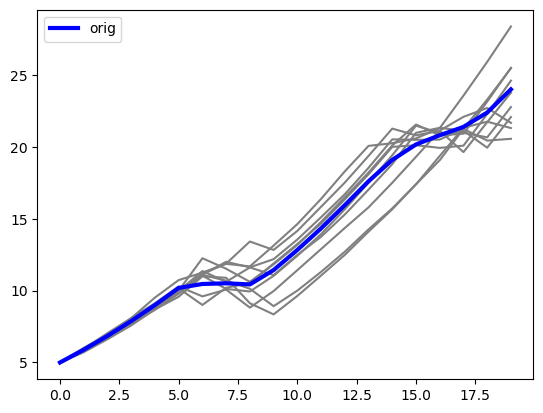

In [1]:
from cps.original_models import *
      

orig_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': 10.,
               's2': 20.}      

orig_traj = generate_traj(gearbox, 500, orig_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='orig')

## SOGA

In [2]:
from optimization import *
torch.set_default_dtype(torch.float64)

Loss value: tensor(7665.2141, grad_fn=<NegBackward0>)


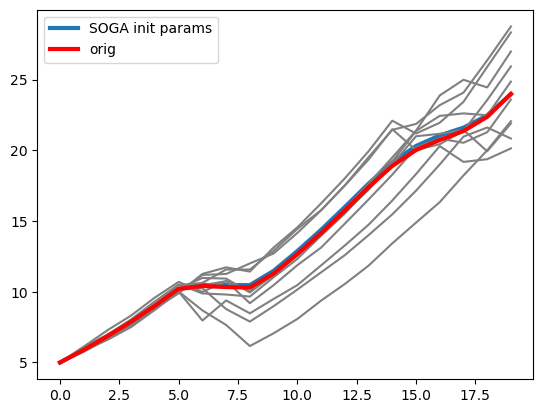

In [3]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s1':10., 's2':20.}
params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict, pruning='ranking')

# loss
T = orig_params['T']
idx = list(range(1, T))
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')


Loss value: tensor(7972.0586, grad_fn=<NegBackward0>)


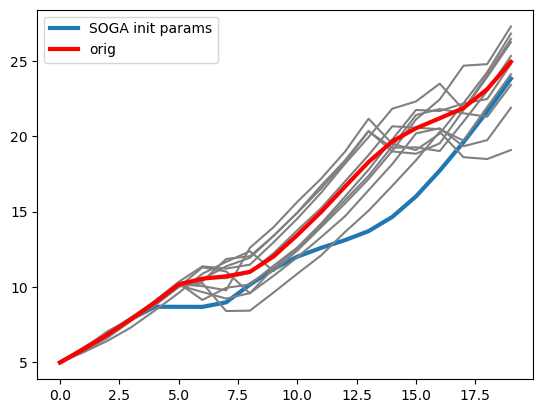

In [12]:
# we choose as initial value of the parameters values for which the loss is higher 
# and there is a significant difference in the mean trajectories

# new cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initial parameters
init_params = {'s1':8., 's2':12.}
params_dict = initialize_params(init_params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# loss
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

s1: 8.149999999996796 s2: 12.149999999998983  loss: 7972.058606906832
s1: 9.497762061536868 s2: 13.641694154444298  loss: 5284.4587973769885
s1: 10.14083809956898 s2: 15.08664572980632  loss: 3545.7354872230753
s1: 9.839992507840119 s2: 16.338924014955076  loss: 2515.962708049646
s1: 9.787049647596113 s2: 17.344372333266545  loss: 2006.6910275406717
s1: 9.995835458169363 s2: 18.11340770778907  loss: 1724.2562801094386
s1: 9.982349315253442 s2: 18.70635803763394  loss: 1578.6490127161571
s1: 9.963486681072608 s2: 19.13205407546604  loss: 1514.188834161462
s1: 10.004382258574061 s2: 19.42033770023992  loss: 1488.1029853063246
s1: 9.98872346204559 s2: 19.608199601144705  loss: 1478.1215056911005
Optimization performed in  251.315
s1: 9.991739843328103
s2: 19.71790193737561


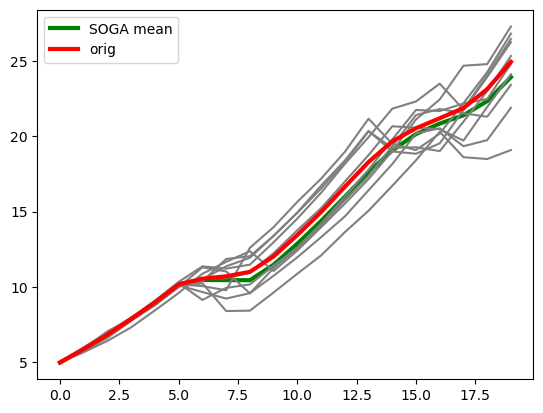

In [15]:
# Optimization in SOGA


# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(init_params)

# Define loss
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=0.15)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Gearbox2.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

## Pyro

In [2]:
from cps.pyro_models import *

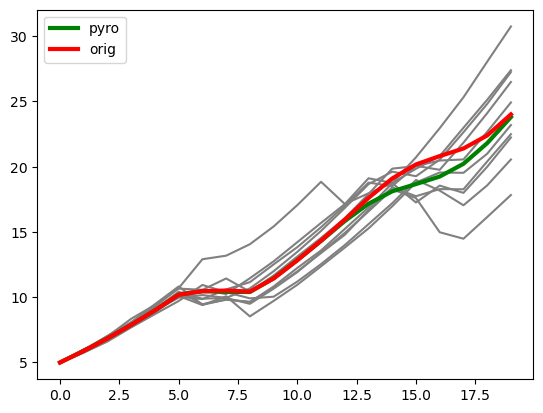

In [4]:
# This is to check that the model works as expected for the right values of the parameters

T = 20
gear = 1
init_v = 5.

def gearbox_pyro_proof(batch_size, eps=1.0):
    
    s1 = pyro.sample("s1", dist.Normal(10., 1.0))
    s2 = pyro.sample("s2", dist.Normal(20., 1.0))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_v

    w = torch.zeros(batch_size)
    gear = torch.ones(batch_size, dtype=torch.long)
    nxt = torch.zeros(batch_size, dtype=torch.long)
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    s = torch.stack([s1, s2])

    dt = 0.1

    for i in range(1, T):
        
        # update gear
        for b in range(batch_size):

            #update velocity
            if gear[b] >= 1:
                traj[b, i] = traj[b, i-1] + dt*traj[b, i-1]*alpha[gear[b]-1] + dt*distributions.Normal(5., 1.).rsample() 
            else:
                traj[b, i] = traj[b, i-1] - dt*0.0005*traj[b, i-1]**2 + distributions.Normal(0., 1.).rsample() 

            # update gear
            if gear[b] >= 1 and gear[b] < 3 and traj[b, i] > s[gear[b]-1]:
                nxt[b] = gear[b] + 1
                gear[b] = 0
                w[b] = 0.2
            elif gear[b] == 0 and w[b] < 0:
                gear[b] = nxt[b]
        
            w[b] = w[b] - dt

    return traj

pyro_traj = gearbox_pyro_proof(batch_size=1000)

plot_traj_set(pyro_traj, single_traj=10, color='green', label='pyro')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

### MCMC

In [6]:
init_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': torch.tensor(8.),       # shift points
               's2': torch.tensor(12.)}


gearbox_pyro = create_gearbox_pyro(init_params, eps=2.0)

# does not converge (low acc. prob)
posterior_samples = run_NUTS(gearbox_pyro, orig_traj, num_samples=50, warmup_steps=10, adapt_step_size=False, step_size=1e-3)

Sample: 100%|██████████| 60/60 [03:30,  3.51s/it, step size=1.00e-03, acc. prob=0.000]


In [7]:
posterior_samples

{'s1': tensor([0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920,
         0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920,
         0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920,
         0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920,
         0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920, 0.4920,
         0.4920, 0.4920, 0.4920, 0.4920, 0.4920]),
 's2': tensor([1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653,
         1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653,
         1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653,
         1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653,
         1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653, 1.1653,
         1.1653, 1.1653, 1.1653, 1.1653, 1.1653])}

### VI Optimization

In [8]:
init_params = {'T': 20,   # time steps
               'init_v': 5.,  # initial velocity
               'gear': 1,      # initial gear
               's1': torch.tensor(8.),       # shift points
               's2': torch.tensor(12.)}


Step 0: Loss = 41711.08974391222
Step 100: Loss = 45713.18992948532
Step 200: Loss = 44462.256715774536
Step 300: Loss = 38872.582023739815
Step 400: Loss = 38849.37370407581
Step 500: Loss = 39994.77201402187
Step 600: Loss = 39717.160367012024
Step 700: Loss = 39520.7787463665
Step 800: Loss = 47092.105803489685
Step 900: Loss = 41020.531078636646
Optimization performed in 3596.04 seconds


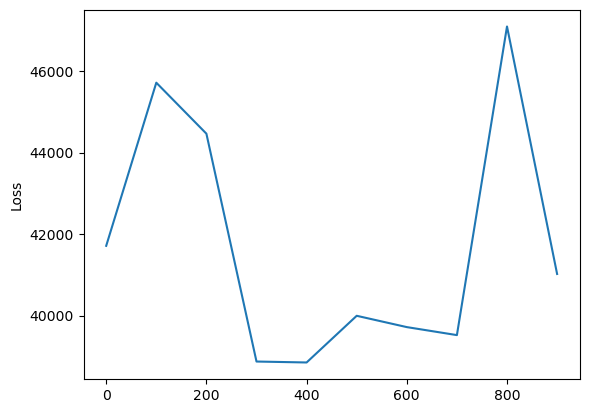

In [ ]:
#gearbox_pyro = create_gearbox_pyro(init_params, eps=1.0)

gearbox_guide = create_gearbox_guide(init_params)

run_SVI(gearbox_pyro, gearbox_guide, orig_traj, num_steps=1000, lr=0.01, num_particles=1, loss_plot=True)

Optimized s1: 8.107597351074219, s2: 11.863809585571289


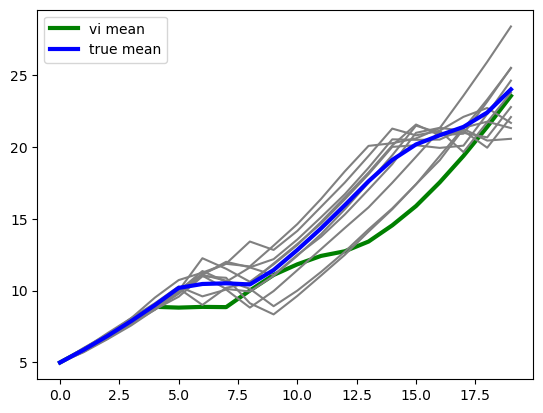

In [10]:
# Retrieve optimized parameters
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()

print(f"Optimized s1: {vi_s1}, s2: {vi_s2}")

# plot

vi_traj = generate_traj(gearbox, 100, {'T': 20,
                                        'init_v': 5.,
                                        'gear': 1,
                                        's1': vi_s1,
                                        's2': vi_s2})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

